## Doc count VS continent/country

In [ ]:
import pandas as pd 
import numpy as np
import json 


In [2]:
data_folder = "/home/linyu.linyu/health/data/cls_output/filter_data/"
data_loc_file = data_folder + "data_loc.csv"
data_loc = pd.read_csv(data_loc_file)

data_file = data_folder + "valid_data.csv"
data = pd.read_csv(data_file)
data = data.dropna()
# len(data)  6106 -> 6105
## len(data.dropna())
print("data size: ", len(data))

data size:  6105


In [3]:
data.columns

Index(['index', 'Title', 'Abstract', 'date_year', 'health_proba',
       'disaster_proba', 'title_char'],
      dtype='object')

In [4]:
### get year distribution
data['date_year'] = data['date_year'].astype('int')
year_distribution = data.date_year.value_counts()
### how to draw the figure? by excel ? or plt 

In [5]:
year_distribution

2021    742
2013    693
2019    624
2020    594
2018    586
2015    577
2016    566
2014    561
2017    521
2012    465
2022    176
Name: date_year, dtype: int64

## stat on country location

In [6]:
### process the doc location, and extract one location for each doc 
data_loc_sub = data_loc.drop_duplicates(subset=['doc_id'], )
data_loc_sub.head(3)


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf
0,Massachusetts,42.36565,-71.10832,USA,6254926,Massachusetts,A,ADM1,0,Massachusetts,USA,0.946707
3,Louisiana,29.95465,-90.07507,USA,4335045,New Orleans,P,PPLA2,4,New Orleans,USA,0.957188
4,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,5,Fukushima,JPN,0.948191


In [7]:
from pycountry_convert import  country_alpha2_to_continent_code, country_alpha3_to_country_alpha2
def country2continent(country):
    try:
        a2 = country_alpha3_to_country_alpha2(country)
        continent = country_alpha2_to_continent_code(a2)
    except:
        return None 
    return continent
#country2continent('JPN')
data_loc_sub['continent'] = data_loc_sub['country_code3'].apply( lambda x: country2continent(x))
#  data_loc_sub['continent'].isna().sum() #21

/home/linyu.linyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
data_loc_sub.continent.value_counts()

AS    2569
NA    1167
EU     399
OC     272
SA     111
AF      79
Name: continent, dtype: int64

## stat on country income

In [9]:
## country income file is downloaded 
## from https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

country_income_file = data_folder + "country_income.csv"
income_data = pd.read_csv(country_income_file, encoding= 'unicode_escape')
#income_data.columns
income_data.head()


,Economy,Code,Region,Income group,Lending category,Other (EMU or HIPC)
0,Aruba,ABW,Latin America & Caribbean,High income,NaN,NaN
1,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD,NaN
3,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN,NaN


In [10]:
country2income = dict()
for i in range(len(income_data)):
    country2income[income_data['Code'].iloc[i]] = income_data['Income group'].iloc[i]

income_map = lambda x: country2income[x] if x in country2income else None
data_loc_sub['income'] = data_loc_sub['country_code3'].apply( income_map )
    

/home/linyu.linyu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
print(len(data_loc_sub))
print(data_loc_sub['income'].isna().sum())
data_loc_sub['income'].value_counts()


4618
56


High income            2646
Upper middle income    1039
Lower middle income     832
Low income               45
Name: income, dtype: int64

In [12]:
data_loc_sub.head()


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income
0,Massachusetts,42.36565,-71.10832,USA,6254926,Massachusetts,A,ADM1,0,Massachusetts,USA,0.946707,NA,High income
3,Louisiana,29.95465,-90.07507,USA,4335045,New Orleans,P,PPLA2,4,New Orleans,USA,0.957188,NA,High income
4,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,5,Fukushima,JPN,0.948191,AS,High income
8,NaN,36.00000,138.00000,JPN,1862185,Honshū Island,T,ISL,6,Honshu,JPN,0.895296,AS,High income
10,Fukushima,37.38158,140.22199,JPN,2112922,Fukushima-ken,A,ADM1,11,Fukushima,JPN,0.951695,AS,High income


In [13]:
out_fp = "/home/linyu.linyu/health/data/cls_output/filter_data/data_country.csv"
data_loc_sub.to_csv(out_fp, index=False)

## Bar figures

In [47]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


def plot_figure(x, y, 
                x_text="x_text", 
                y_text="y_text",
                figure="line",
                file_path=None,
                rotation=False,
               ):
    ## x: label, y: values
    fig = plt.figure(figsize=(10,6))
    if figure=="line":
        plt.plot(x, y, 'o-',)
        plt.xlabel(x_text, labelpad=10) #, fontsize=16)
        plt.ylabel(y_text, labelpad=10) #, fontsize=16)
        plt.xticks(x)
        plt.grid(True, )
    elif figure=="bar":
        angle = 90 if rotation else 0
        plt.bar(x, y,  width=0.5, color="cornflowerblue", ) 
        plt.xticks( x, rotation=angle)
        plt.xlabel(x_text, labelpad=10) #, fontsize=16)
        plt.ylabel(y_text, labelpad=10) #, fontsize=16)
    
    
        
    if file_path:
        pp = PdfPages(file_path)
        pp.savefig(fig)
        pp.close()

    #file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_2.png"
    #plt.savefig(file_path, dpi=300) 
    
    return 
    

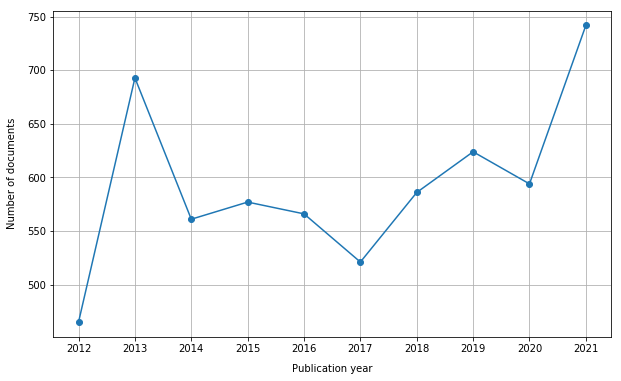

In [48]:
year_dist = year_distribution.to_dict()
years = list(range(2012, 2022, 1))
doc_cnt = [year_dist[y] for y in years ]
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_2.pdf"

plot_figure( years, doc_cnt, 
            x_text="Publication year", 
            y_text="Number of documents",
            figure="line",
            file_path=file_path
        )
plt.show()

x1, y1 = years, doc_cnt


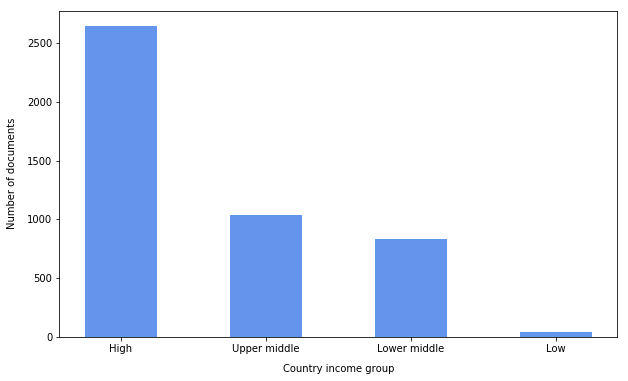

In [16]:
incomes = data_loc_sub['income'].value_counts().to_dict()

labels = ["High", "Upper middle", "Lower middle", "Low"]
keys = ['High income', 'Upper middle income', 'Lower middle income', 'Low income']

doc_cnt = [incomes[k] for k in keys ]
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_3.pdf"

plot_figure( labels, doc_cnt, 
            x_text="Country income group", 
            y_text="Number of documents",
            figure="bar",
            file_path=file_path
        )
plt.show()

x2, y2 = labels, doc_cnt, 


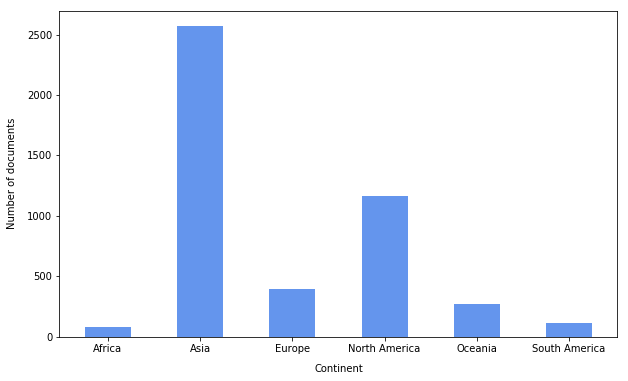

In [17]:
continent_map = {
    "NA": "North America",       
    "EU": "Europe", 
    "OC": "Oceania", 
    "AF": "Africa", 
    "SA": "South America",
    "AS": "Asia"
}    
 
continents = data_loc_sub.continent.value_counts().to_dict()

abbrs = sorted(list( continent_map.keys() ))

labels = [ continent_map[abbr] for abbr in abbrs ]
doc_cnt = [continents[k] for k in abbrs ]
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_4.pdf"

plot_figure( labels, doc_cnt, 
            x_text="Continent", 
            y_text="Number of documents",
            figure="bar",
            file_path=file_path
        )
plt.show()

x3, y3 = labels, doc_cnt, 


## plot in one figure 

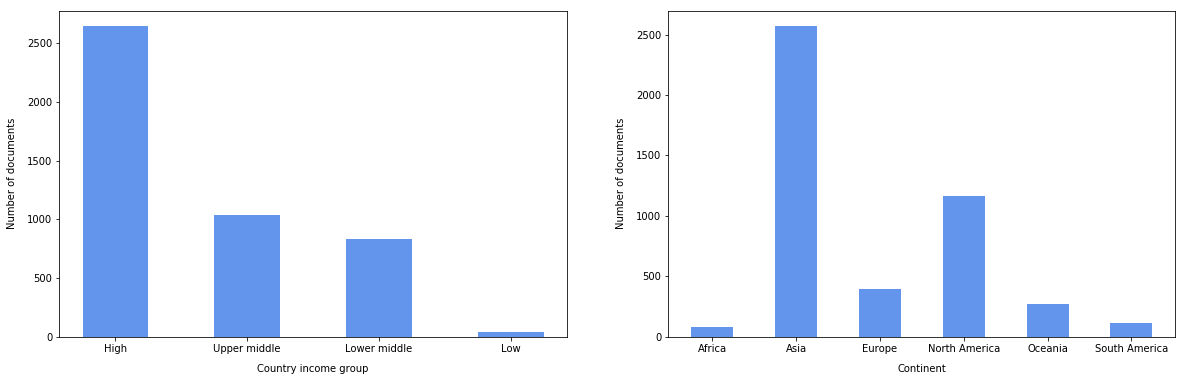

In [37]:

fig = plt.figure(figsize=(20,6))
"""
plt.subplot(2, 1, 1)
x_text="Publication year"
y_text="Number of documents"
plt.plot(x1, y1, 'o-',)
plt.xlabel(x_text, fontsize=16)
plt.ylabel(y_text, fontsize=16)
plt.grid(True)
"""

plt.subplot(1, 2, 1)
x_text="Country income group"
y_text="Number of documents"
plt.bar(x2, y2, width=0.5, color="cornflowerblue") # 
plt.xlabel(x_text, labelpad=10)
plt.ylabel(y_text, labelpad=10)


plt.subplot(1, 2, 2)
x_text="Continent"
y_text="Number of documents"
plt.bar(x3, y3, width=0.5, color="cornflowerblue")
plt.xlabel(x_text,  labelpad=10) # fontsize=16, 
plt.ylabel(y_text, labelpad=10)
 
from matplotlib.backends.backend_pdf import PdfPages
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_combine.pdf"
pp = PdfPages(file_path)
pp.savefig(fig)
pp.close()
plt.show()


In [62]:
print(len(data_loc_sub))
data_loc_sub[data_loc_sub['country_code3'].isna() ]

4618


,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income
1569,NaN,0.00000,0.00000,NaN,6295630,Earth,L,AREA,671,Earth,NaN,0.813797,None,NaN
1678,NaN,48.69096,9.14062,NaN,6255148,Europe,L,CONT,719,europe,NaN,0.879922,None,NaN
1965,NaN,32.16667,135.00000,NaN,1879924,Nankai Trough,U,TRGU,869,Nankai Trough,NaN,0.904877,None,NaN
2490,NaN,34.88593,22.36816,NaN,6947194,Eastern Mediterranean,H,SEA,1157,Eastern Mediterranean,NaN,0.835962,None,NaN
4709,NaN,0.00000,0.00000,NaN,6295630,Earth,L,AREA,2058,earth,NaN,0.879922,None,NaN
5041,NaN,12.38293,103.00781,NaN,6942346,Southeast Asia,L,RGN,2203,southeast Asia,NaN,0.771986,None,NaN
6919,NaN,46.07323,-100.54688,NaN,6255149,North America,L,CONT,2979,America,NaN,0.852964,None,NaN
8177,NaN,6.83917,116.45508,NaN,7729896,South Eastern Asia,L,RGN,3496,South Eastern,NaN,0.813797,None,NaN
8225,NaN,0.00000,0.00000,NaN,6295630,Earth,L,AREA,3516,earth,NaN,0.879922,None,NaN
10779,NaN,0.00000,0.00000,NaN,6295630,Earth,L,AREA,4644,earth,NaN,0.781642,None,NaN


In [18]:
data_loc_sub[ data_loc_sub['income'].isna() ]

,admin1,lat,lon,country_code3,geonameid,place_name,feature_class,feature_code,doc_id,word,country_predicted,country_conf,continent,income
1014,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,426,Indian Ocean,IOT,0.813797,AS,None
1069,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,448,Indian Ocean,IOT,0.813797,AS,None
1161,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,499,Indian Ocean,IOT,0.813797,AS,None
1227,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,542,Indian Ocean,IOT,0.813797,AS,None
1430,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,612,Indian Ocean,IOT,0.879922,AS,None
1569,NaN,0.00000,0.00000,NaN,6295630,Earth,L,AREA,671,Earth,NaN,0.813797,None,NaN
1678,NaN,48.69096,9.14062,NaN,6255148,Europe,L,CONT,719,europe,NaN,0.879922,None,NaN
1775,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,763,Indian Ocean,IOT,0.799130,AS,None
1965,NaN,32.16667,135.00000,NaN,1879924,Nankai Trough,U,TRGU,869,Nankai Trough,NaN,0.904877,None,NaN
2029,NaN,-6.00000,72.00000,IOT,1282588,British Indian Ocean Territory,A,PCLD,910,Indian Ocean,IOT,0.813797,AS,None


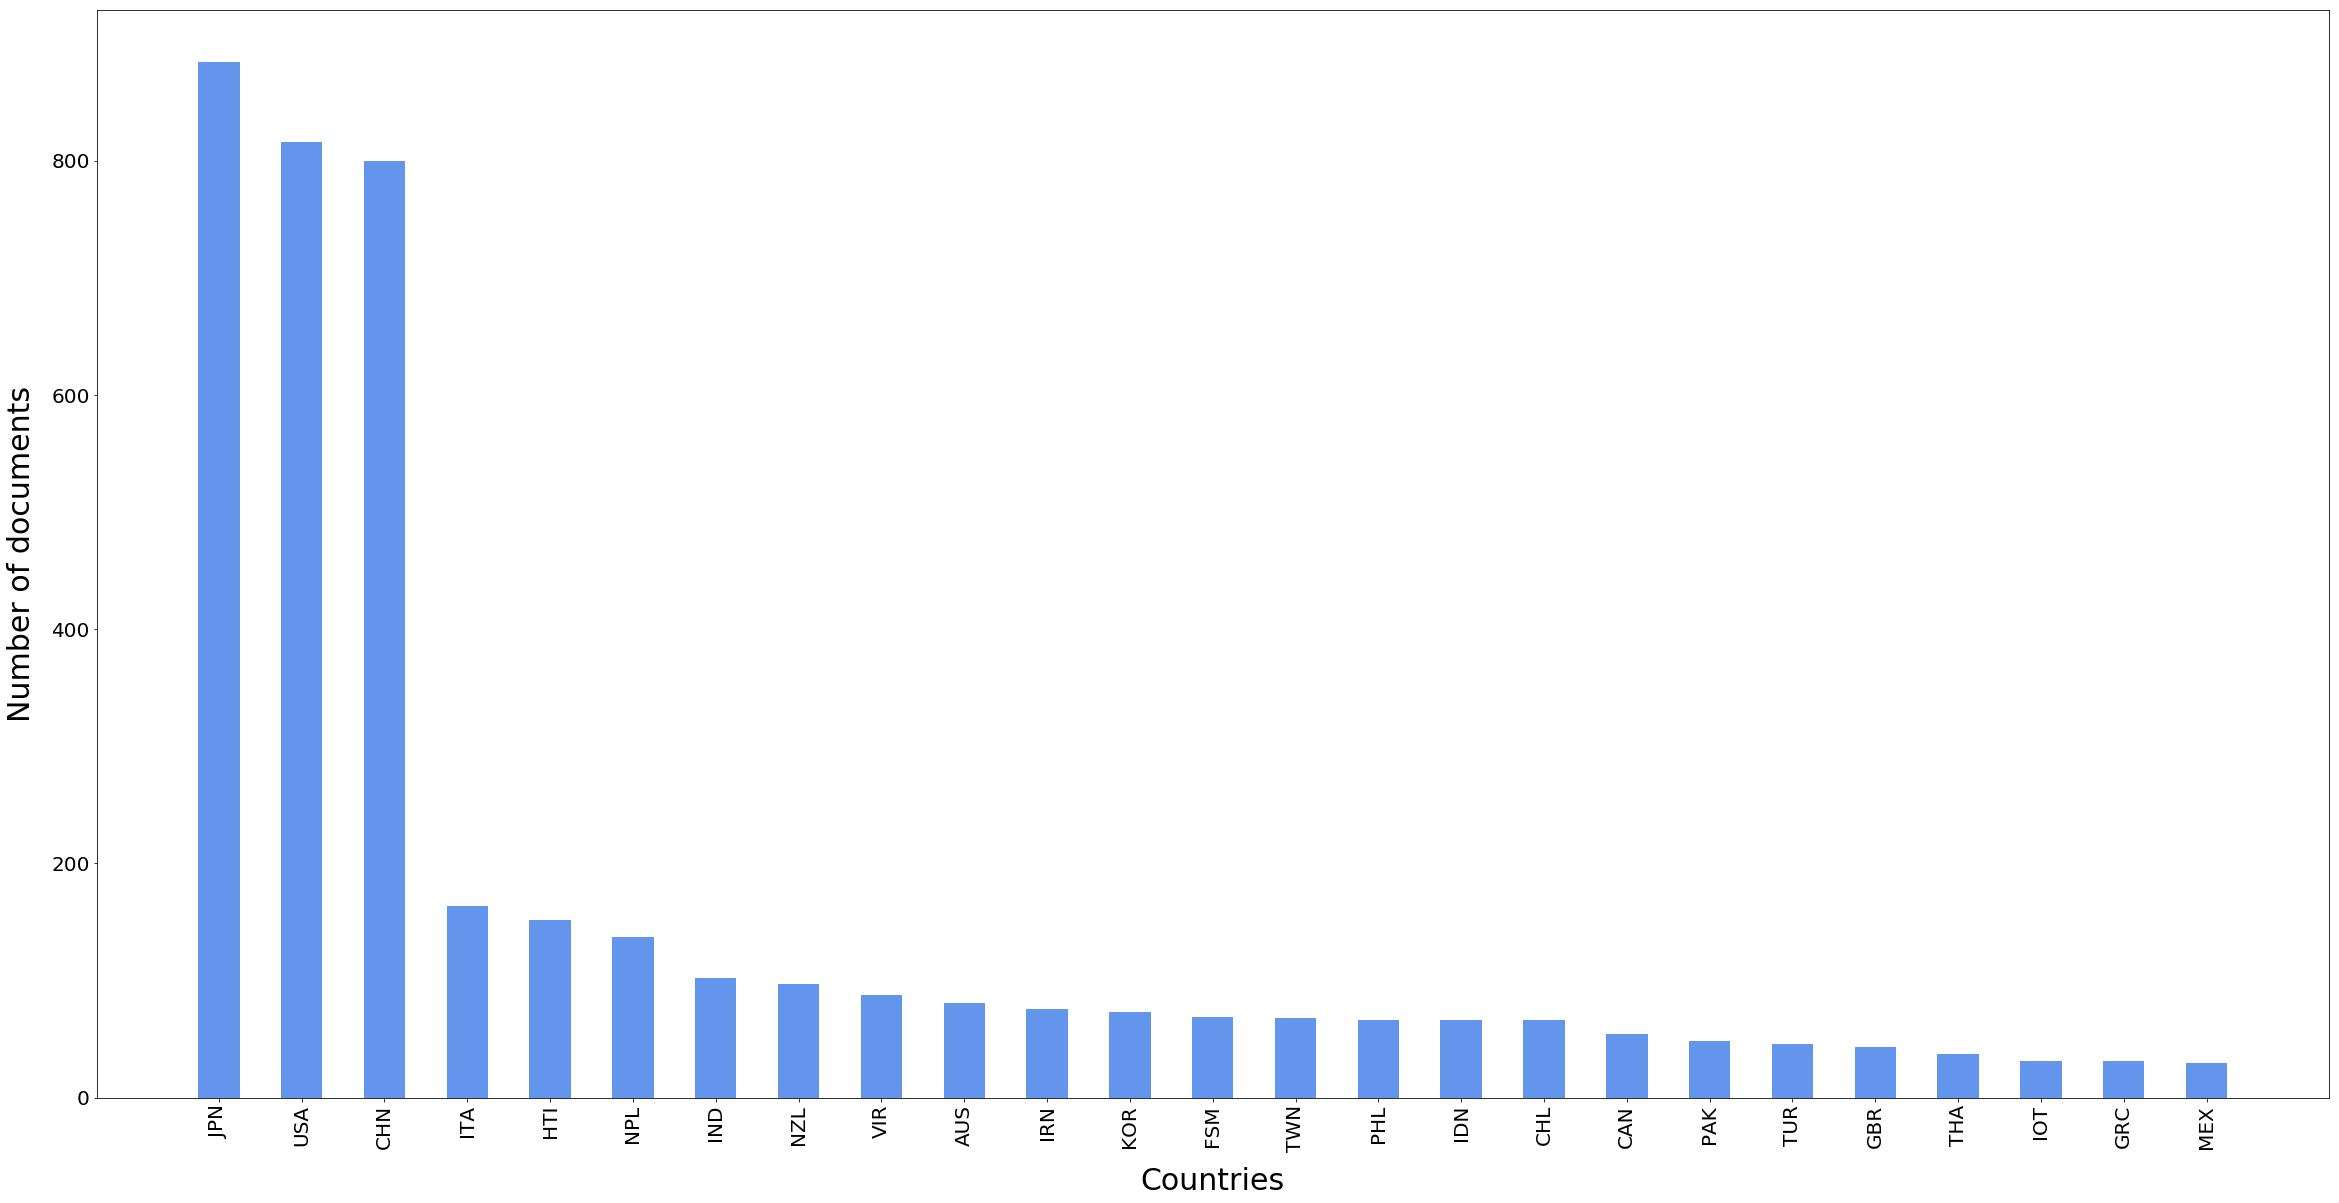

In [24]:

def plot_bar(x, y, 
                x_text="x_text", 
                y_text="y_text",
                figure="line",
                file_path=None,
                rotation=False,
               ):
    ## x: label, y: values
    #fig = plt.figure(figsize=(10,6))
    fig, ax = plt.subplots() #dpi=150, figsize=(12,6))
    plt.rcParams["figure.figsize"] = (40,20)
    #fig = plt.figure(figsize=(40,6))  ## 20，6

    if figure=="bar":
        angle = 90 if rotation else 0
        plt.bar(x, y,  width=0.5, color="cornflowerblue", )
        plt.xticks( x, rotation=angle, fontsize=20)
        plt.yticks(fontsize=20)
        #plt.yticks( y, rotation=angle, fontsize=20)
        plt.xlabel(x_text, labelpad=15, fontsize=30)
        plt.ylabel(y_text, labelpad=15, fontsize=30)
        
    if file_path:
        pp = PdfPages(file_path)
        pp.savefig(fig)
        pp.close()
    #file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_2.png"
    #plt.savefig(file_path, dpi=300) 
    return 
    

country_count = data_loc_sub['country_code3'].value_counts()
country_count_ = [[y, x] for x, y in country_count.items() ]

count_cut = 30 
other_country = "Others"
other_count = sum([lst[0] for lst in country_count_ if lst[0] < count_cut ])

country_count_ = [lst for lst in country_count_ if lst[0] >= count_cut ]
#country_count_.append( [other_count, other_country ] )
country_count_.sort(reverse=True)

labels = [lst[1] for lst in country_count_ ]
doc_cnt = [lst[0] for lst in country_count_ ]
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_country.pdf"

plot_bar( labels, doc_cnt, 
            x_text="Countries", 
            y_text="Number of documents",
            figure="bar",
            file_path=file_path,
            rotation=True
        )
plt.show()

x4, y4 = labels, doc_cnt

In [54]:
sum(country_count)

4600

## combine 3 figures 


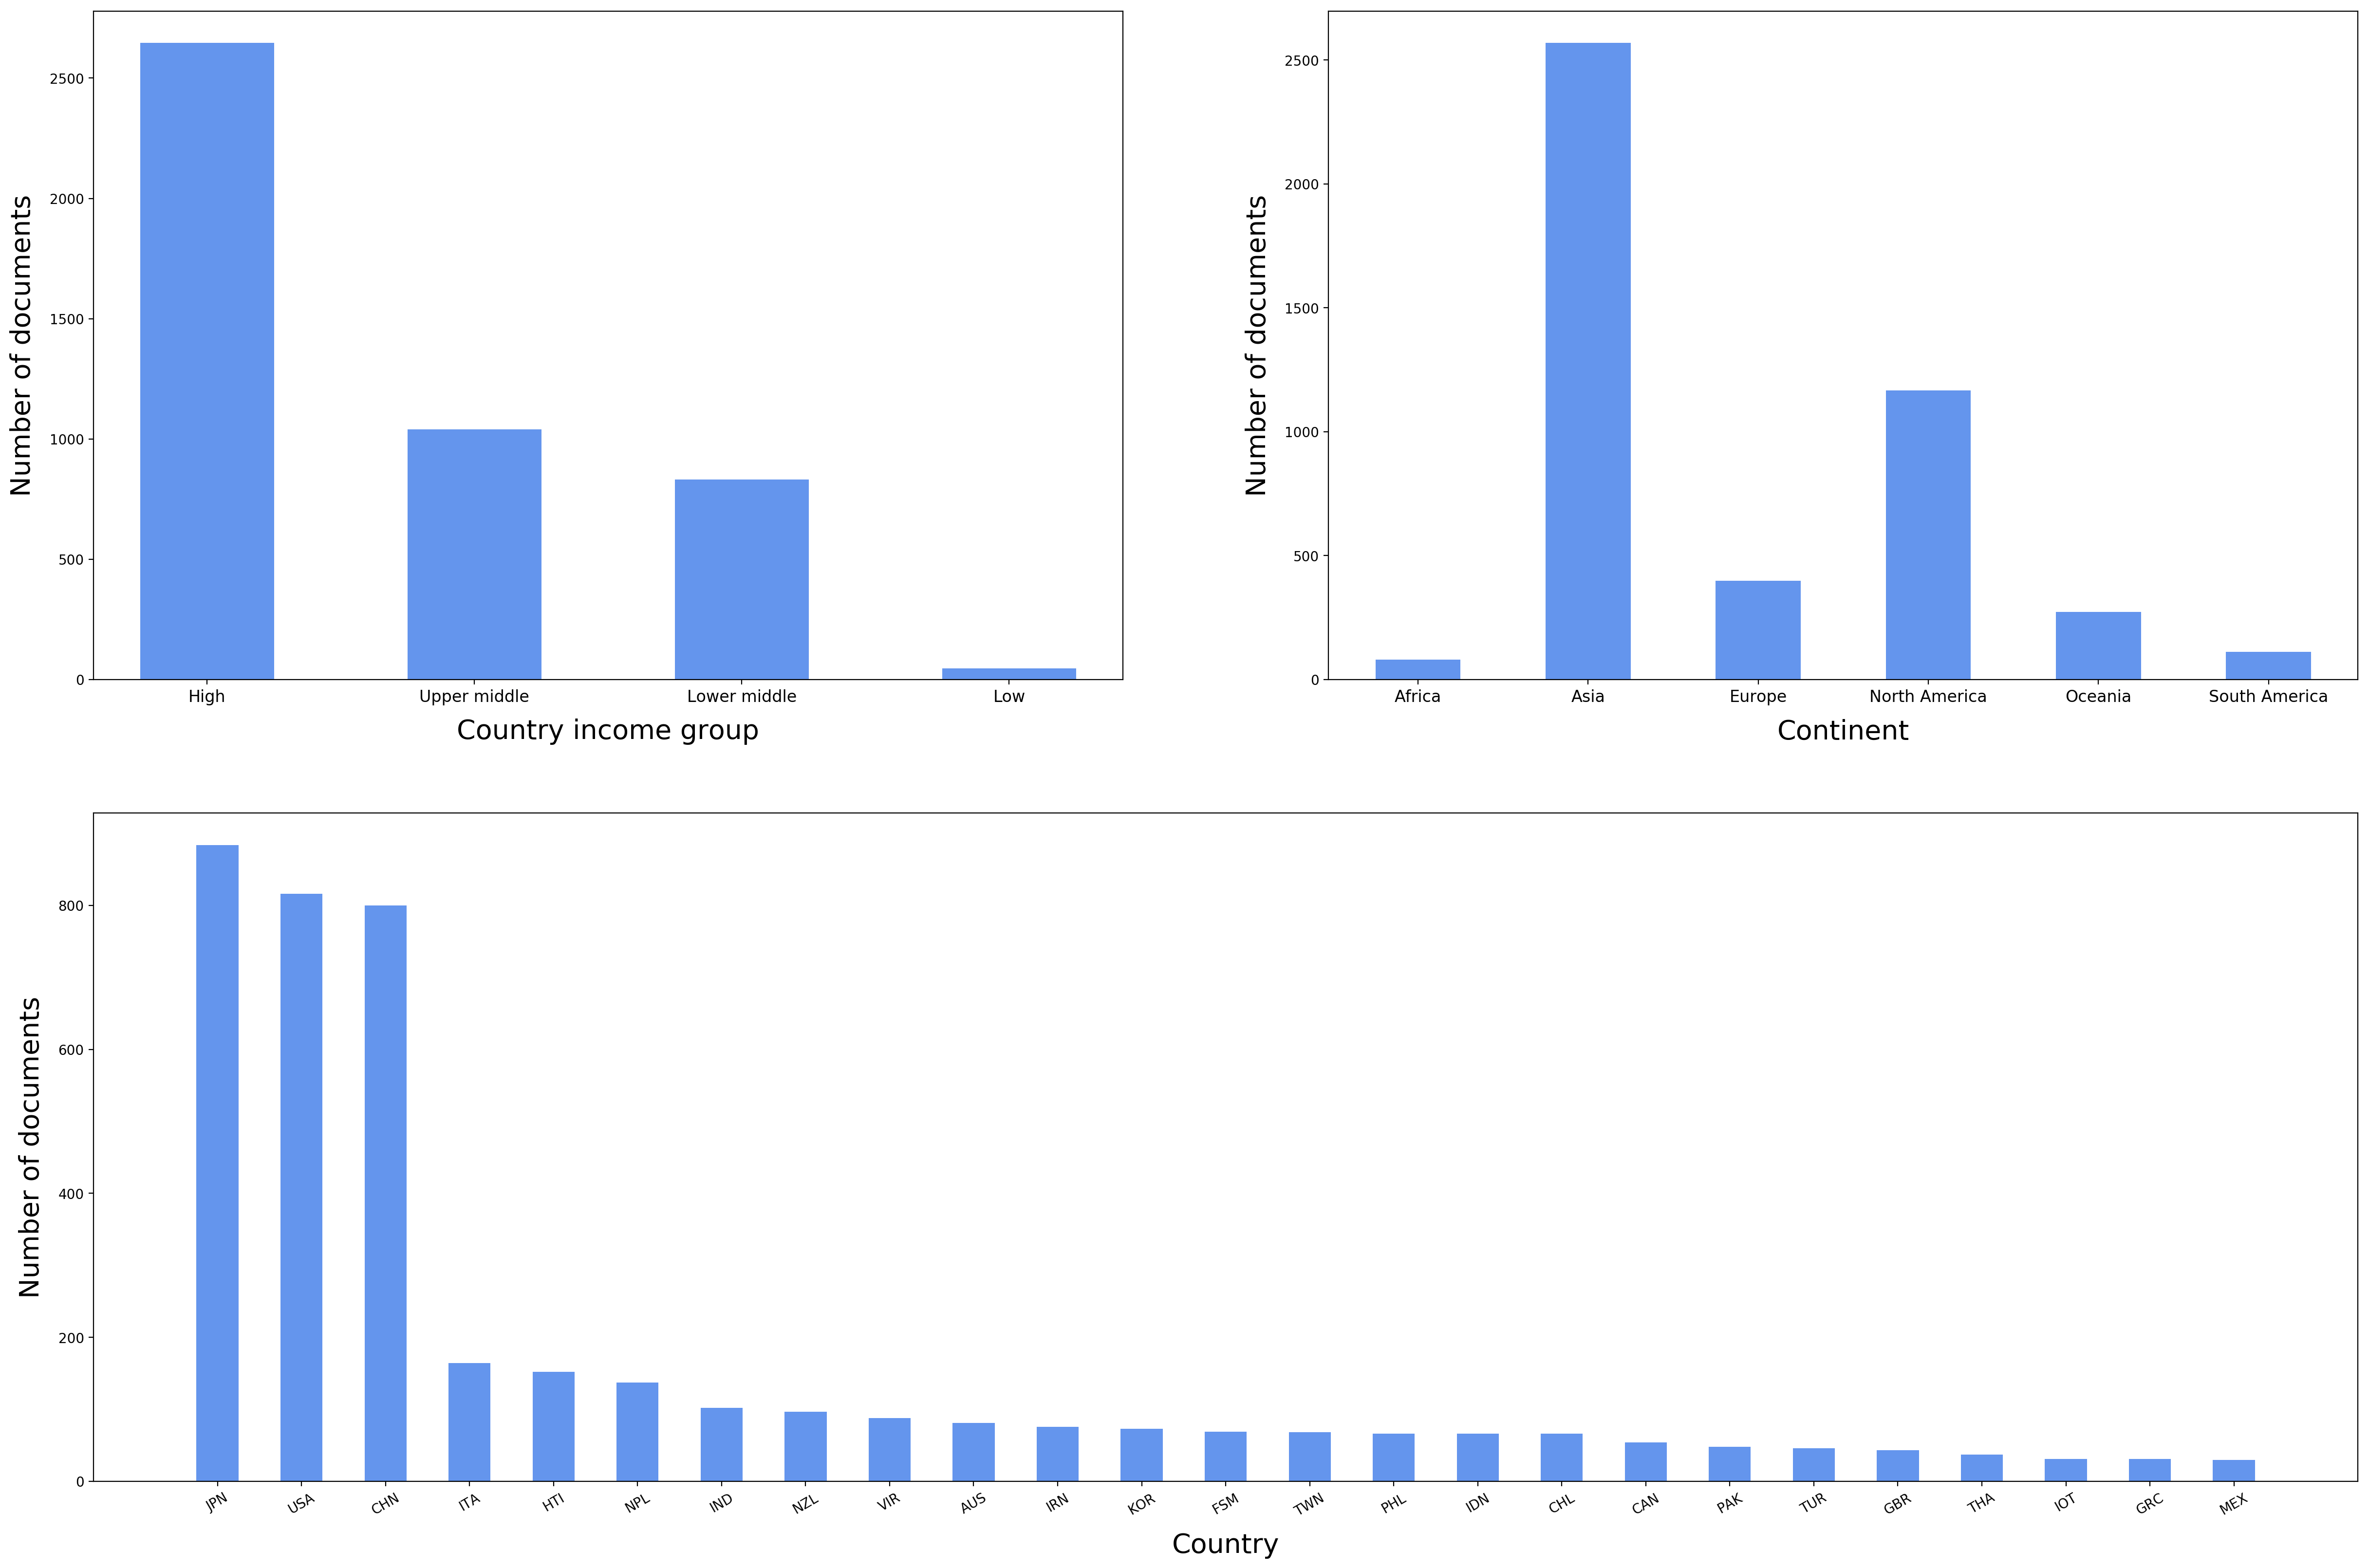

In [42]:

fig = plt.figure(figsize=(30,20), dpi=200, )

ticks_font=12
label_font=20

plt.subplot(2, 2, 1)
x_text="Country income group"
y_text="Number of documents"
plt.bar(x2, y2, width=0.5, color="cornflowerblue") # 
plt.xticks( x2, fontsize=ticks_font )
plt.xlabel(x_text, labelpad=10,  fontsize=label_font )
plt.ylabel(y_text, labelpad=10,  fontsize=label_font )


plt.subplot(2, 2, 2)
x_text="Continent"
y_text="Number of documents"
plt.bar(x3, y3, width=0.5, color="cornflowerblue")
plt.xticks( x3, fontsize=ticks_font )
plt.xlabel(x_text,  labelpad=10, fontsize=label_font) # fontsize=16, 
plt.ylabel(y_text, labelpad=10, fontsize=label_font)



plt.subplot(2, 1, 2)
x_text="Country"
y_text="Number of documents"
plt.bar(x4, y4 , width=0.5, color="cornflowerblue")
plt.xticks( x4, rotation=30, fontsize=10 )
plt.xlabel(x_text, labelpad=10,  fontsize=label_font) #
plt.ylabel(y_text, labelpad=10,  fontsize=label_font)


from matplotlib.backends.backend_pdf import PdfPages
file_path="/home/linyu.linyu/health/data/cls_output/figure_out/figure1_combine3.pdf"
pp = PdfPages(file_path)
pp.savefig(fig)
pp.close()

plt.show()

